# Introduction

This is a lab for experimenting with trend-following ideas and techniques.  It includes the following features:

1. Data: downloads historical price data from various sources as input to the experiments.  It also simulates price data with various models to test different strategies.
1. `tr` class: a class for trading strategies upon a single asset.
1. `po` class: a class for portfolio evaluation: select assets, excecute trading strategies and evaluate performance.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pickle
import itertools
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [12, 4]

import ipyparallel as ipp

import quandl

# Data

The main sources of data are `Quandl`, `Cryptocompare` and `Yahoo Finance`.

In [3]:
from utils import *

In [4]:
api_key = open(file='quandl_api').read().replace('\n', '')
quandl.ApiConfig.api_key = api_key

In [5]:
# tickers, prices = get_quandl_edi(list(QUANDL_FREE_SAMPLES_EDI.keys()))
# tickers, prices = get_quandl_sharadar(download=True)  # The first time...
tickers, prices = get_quandl_sharadar()
print('Number of price series:', len(tickers))

Number of price series: 30


# Trading Strategies

## Definitions

In [14]:
from trading_strategies import *
test_RS_Trading_Strategy()

## Trading Tribe example

Here, we reproduce Ed Sykota's trading tribe [example](http://www.seykota.com/tribe/tsp/SR/SYS_SR_140-20_05_v_15/index.htm) on a Support and Resistance trading system.

In [15]:
price = pd.read_csv(filepath_or_buffer='test/Seykota GC----C.csv', header=None,
                   names=['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Open_Interest'], 
                   index_col=0)
price.index = [datetime.strptime(str(i), '%Y%m%d') for i in price.index.values]

In [140]:
%%time
rs_tr = RS_Trading_Strategy(price, equity=1e6, position_step=1e2,
                            days_fast=20, days_slow=140, name='Comex Gold')
rs_tr.excecute(warmup=20)

CPU times: user 535 ms, sys: 10.5 ms, total: 546 ms
Wall time: 541 ms


In [141]:
rs_tr.performance
# rs_tr.get_state()
# rs_tr.get_trades()
# rs_tr.get_equity()

{'Years': 30.745367192862044,
 'Ratio': 2.5855,
 'ICAGR': 0.03089632681552998,
 'Max_Drawdown': 0.40774762925090646,
 'Bliss': 0.07577316113962738,
 'Volatility': 0.160627736025579,
 'Lake_Ratio': 0.17595887397049154,
 'Sea_Ratio': 0.3073924855686487}

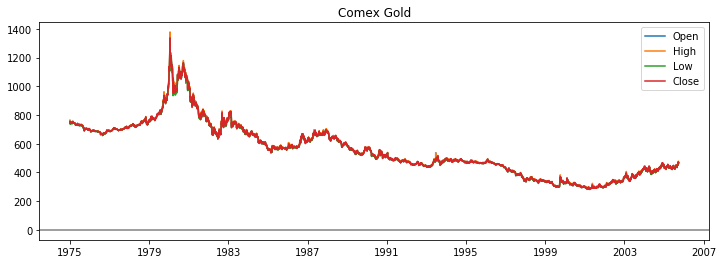

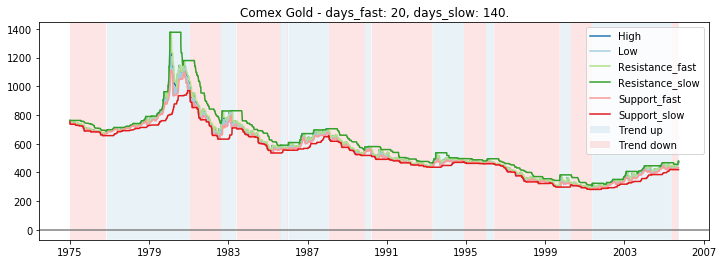

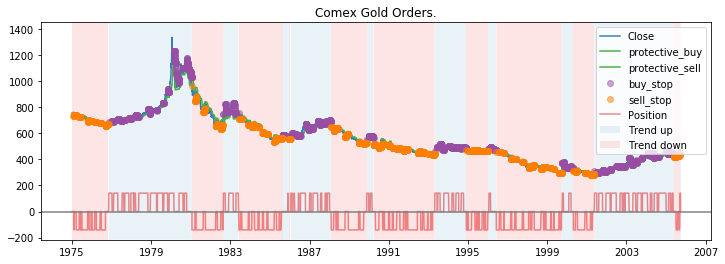

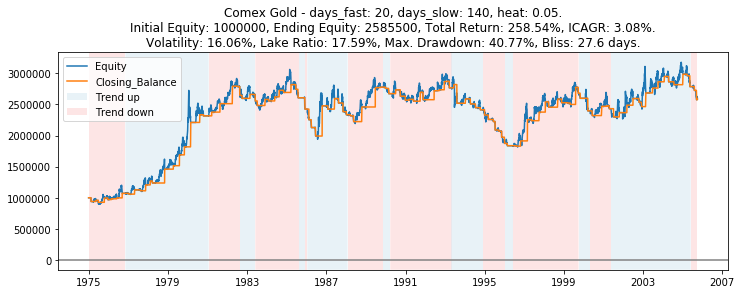

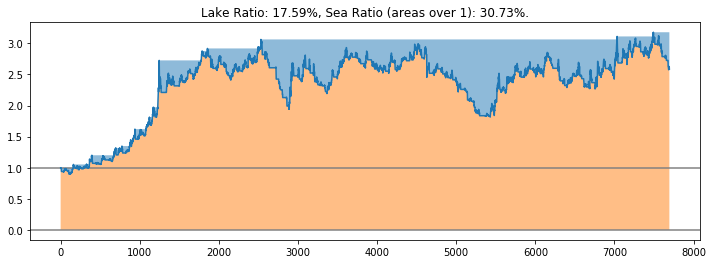

In [142]:
rs_tr.plot_prices()
rs_tr.plot_state()
rs_tr.plot_orders()
rs_tr.plot_equity()
rs_tr.plot_lake_ratio()

## With a random asset

* TO DO: curate series. Eg.:
    * XNAS/AAPL
    * XTSX/AMK
    * XTSE/ACD
    * XTSX/ADK
    * XTSX/ALZ
    * XTSX/ADK
    * XSES/A04
    * XTSX/AHR
    * XTSX/ADD
    * XTSX/AME
    * XHKG/00004

MCD - 4912 days.


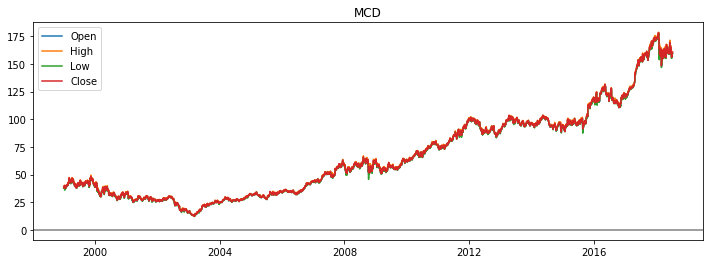

In [71]:
j = np.random.choice(len(tickers) - 1)
ticker_j = tickers[j]
pr_j = prices.loc[ticker_j]
print(ticker_j, '-', len(pr_j), 'days.')
plot_prices(pr_j, ticker_j)

In [20]:
rs_j = RS_Trading_Strategy(pr_j, equity=1e6, days_fast=60, days_slow=140, name=str(j) + ' - ' + ticker_j)
rs_j.excecute()

In [21]:
rs_j.performance

{'Years': 19.470144131777626,
 'Ratio': 0.5014945045000001,
 'ICAGR': -0.035447227565171525,
 'Max_Drawdown': 0.5821889441027991,
 'Bliss': -0.06088612283731806,
 'Volatility': 0.08650489769879417,
 'Lake_Ratio': 0.6912578764408328,
 'Sea_Ratio': -1.2414258802483737}

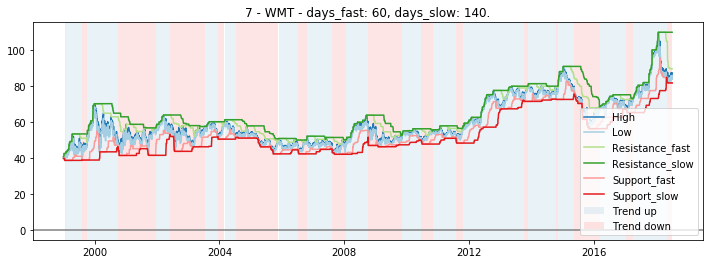

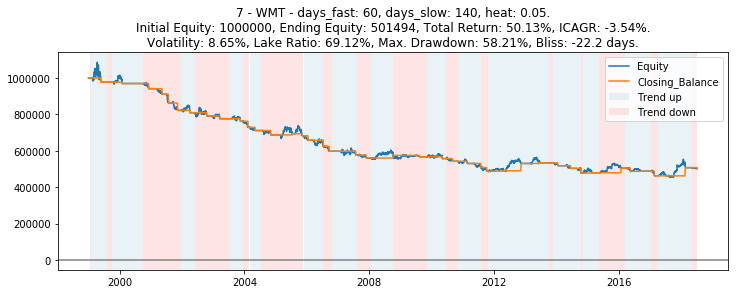

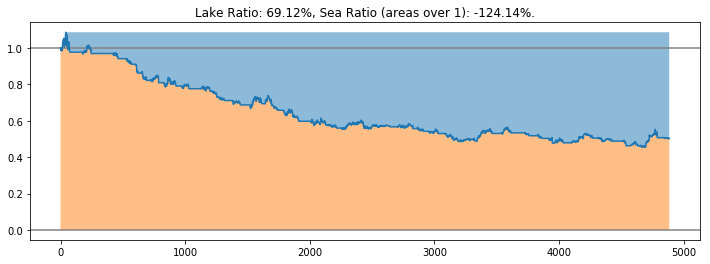

In [22]:
rs_j.plot_state()
rs_j.plot_equity()
rs_j.plot_lake_ratio()

### Optimizing hyper parameters

#### Grid Search

In [59]:
res_search = grid_search(pr_j, ticker_j, step=40)

In [64]:
res_train = res_search.set_index('Type').loc['Train'].reset_index()
res_val = res_search.set_index('Type').loc['Validation'].reset_index()

In [65]:
res_search

,Name,Slow,Fast,Type,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Volatility,Lake_Ratio,Sea_Ratio
0,TSLA,100,20,Train,3.632121,1.481270,0.108174,0.340862,0.317354,0.168486,0.144534,0.705092
0,TSLA,140,20,Train,3.632121,1.729845,0.150885,0.254756,0.592272,0.174303,0.126276,0.409875
0,TSLA,140,60,Train,3.632121,1.537752,0.118477,0.278855,0.424869,0.148840,0.223172,0.875988
0,TSLA,180,20,Train,3.632121,1.729845,0.150885,0.254756,0.592272,0.174303,0.126276,0.409875
0,TSLA,180,60,Train,3.632121,1.537752,0.118477,0.278855,0.424869,0.148840,0.223172,0.875988
...,...,...,...,...,...,...,...,...,...,...,...,...
0,TSLA,380,140,Validation,4.027454,0.882888,-0.030927,0.126598,-0.244292,0.053301,0.081012,-1.151443
0,TSLA,380,180,Validation,4.027454,0.884338,-0.030520,0.121560,-0.251065,0.051470,0.070875,-1.098551
0,TSLA,380,220,Validation,4.027454,0.931489,-0.017622,0.098269,-0.179322,0.048232,0.045395,-1.158385
0,TSLA,380,260,Validation,4.027454,0.916662,-0.021606,0.090652,-0.238341,0.040200,0.045602,-1.157592


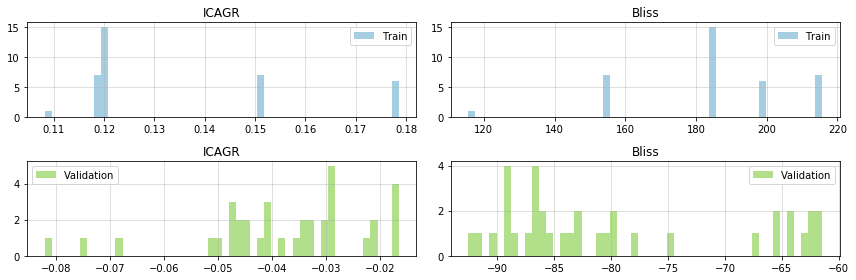

In [66]:
pal = pyplot.get_cmap('Paired').colors

plt.subplot(2, 2, 1)
plt.title('ICAGR')
plt.hist(res_train.ICAGR, bins = 50, label='Train', color=pal[0])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Bliss')
plt.hist(res_train.Bliss * 364.25, bins = 50, label='Train', color=pal[0])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 3)
plt.title('ICAGR')
plt.hist(res_val.ICAGR, bins = 50, label='Validation', color=pal[2])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 4)
plt.title('Bliss')
plt.hist(res_val.Bliss * 364.25, bins = 50, label='Validation', color=pal[2])
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()

TSLA - Color: Bliss (days)


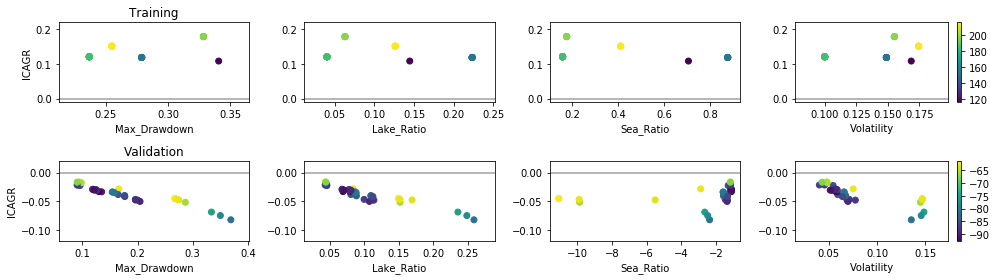

In [67]:
y_lab = ['ICAGR']
x_lab = ['Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']
c_lab = 'Bliss'

print(ticker_j, '- Color: ' + c_lab + ' (days)')
fig, axes = plt.subplots(nrows=2 * len(y_lab), ncols=len(x_lab), squeeze=False, figsize=(14, 4))

axes[0, 0].set_title('Training')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[i, j].scatter(res_train[x_lab[j]], res_train[y_lab[i]], c=res_train[c_lab] * 364.25)
    axes[i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[i, j])

axes[1, 0].set_title('Validation')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[1 + i, j].scatter(res_val[x_lab[j]], res_val[y_lab[i]], c=res_val[c_lab] * 364.25)
    axes[1 + i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[1 + i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[1 + i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[1+i, j])
plt.tight_layout()

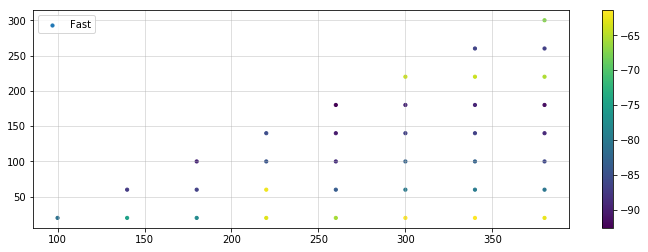

In [68]:
plt.scatter(res_val.Slow, res_val.Fast, s= 10 + 100 * (res_val.ICAGR > 0),
            c= 364.25 * res_val.Bliss)
plt.colorbar()
plt.grid(alpha=0.5)
plt.legend()

### 3.3.2 Best configuration

In [ ]:
res_train.Bliss[res_train.Bliss > 0]

In [ ]:
best_conf = res_train[['Slow', 'Fast']].iloc[res_train.ICAGR.idxmax()]
best_conf = res_train[['Slow', 'Fast', 'Bliss']][res_train.Bliss > 0].sort_values(by='Bliss').head(1)
best_conf[['Slow', 'Fast']].iloc[0]

In [ ]:
s, f = best_conf[['Slow', 'Fast']].iloc[0]; print(ticker_j, s, f, sep=', ')
tr_j = RS_Trading_Strategy(pr_j, equity=1e6, 
                           days_fast=int(f), days_slow=int(s),
                           name=str(j) + ' - ' + ticker_j)
tr_j.excecute(warmup=0.5)

In [ ]:
tr_j.performance
# tr_j.get_equity()

In [ ]:
tr_j.plot_state()
tr_j.plot_equity()
tr_j.plot_lake_ratio()

# Multiple Assets

In [82]:
n_assets = 100
tickers = [list(prices_dict)[i] for i in np.random.choice(len(prices_dict), size=n_assets, replace=False)]; print(tickers)
prices = [prices_dict[t] for t in tickers]

['XSES/AVX', 'XSES/BEC', 'XSHE/200418', 'XLON/AGK', 'XNAS/ACLS', 'XTSE/ALA', 'XSHE/200055', 'XNAS/AAON', 'XSHG/600017', 'XTSX/AME', 'XNYS/ABC', 'XBOM/500031', 'XTSE/AEM', 'XTSE/ACD', 'XASE/ACY', 'XASE/ACU', 'XBOM/500027', 'XSHE/200530', 'XTSE/AGU', 'XNYS/AB', 'XSHG/600009', 'XNSE/BBL', 'XSES/BESU', 'XNAS/ABG', 'XLON/ADT', 'XSES/AGS', 'XTSX/AHR', 'XSES/1B6', 'XASE/BFY', 'XTSE/ABX', 'XSHE/200011', 'XASE/BHV', 'XLON/AEO', 'XTSE/AGT', 'XHKG/00018', 'XHKG/00004', 'XBOM/500013', 'XSES/BCY', 'XASE/ADK', 'XNYS/ABM', 'XNAS/AAME', 'XLON/ABBY', 'XSHG/600011', 'XNSE/BASF', 'XNSE/BIOCON', 'XNAS/ABM', 'XTSE/ALB', 'XBOM/500002', 'XASE/BDL', 'XASE/AMS', 'XSHG/600026', 'XHKG/00015', 'XNSE/ACE', 'XSHG/600021', 'XNSE/AFL', 'XNSE/BASML', 'XNAS/ACNB', 'XASE/BTI', 'XBOM/500040', 'XSHG/600012', 'XSES/AUE', 'XNSE/ALICON', 'XHKG/00011', 'XNAS/ABAC', 'XSHG/600004', 'XNYS/ABBV', 'XNAS/ACIW', 'XSHG/600010', 'XHKG/00008', 'XHKG/00010', 'XTSE/ALO', 'XTSX/ALZ', 'XBOM/500020', 'XSES/BBW', 'XLON/ADM', 'XNAS/ABCO', 'XN

In [83]:
import ipyparallel as ipp

rc = ipp.Client()
rc[:].use_dill()
rc.ids

[0, 1, 2, 3, 4, 5, 6]

In [84]:
%%px --local
import itertools
import numpy
import pandas
from pandas import Series, DataFrame
from datetime import datetime
import matplotlib
from matplotlib import pyplot
import matplotlib.transforms
import trading_strategies

In [85]:
view = rc.load_balanced_view()

In [220]:
results = view.map_sync(lambda x: trading_strategies.grid_search(**x, step=5),
                        [{'price_df':p, 'name': t} for p, t in zip(prices, tickers)])

In [232]:
results_df = pd.concat(results)
res_train = results_df.loc[results_df.Type == 'Train']
res_val = results_df.loc[results_df.Type == 'Validation']
with open('output/RS_results_df.pickle', 'wb') as f:
    pickle.dump(results_df, f, pickle.HIGHEST_PROTOCOL)

In [233]:
results_df

,Name,Slow,Fast,Type,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Volatility,Lake_Ratio,Sea_Ratio
0,XSES/AVX,70,20,Train,5.463281,0.771655,-0.047447,0.444491,-0.106745,0.176180,0.406548,-3.446813
0,XSES/AVX,75,20,Train,5.463281,0.771655,-0.047447,0.444491,-0.106745,0.176180,0.406548,-3.446813
0,XSES/AVX,75,25,Train,5.463281,0.833978,-0.033231,0.391639,-0.084850,0.120757,0.315902,-5.280656
0,XSES/AVX,80,20,Train,5.463281,0.829629,-0.034188,0.365089,-0.093642,0.197031,0.302249,-3.280463
0,XSES/AVX,80,25,Train,5.463281,0.830239,-0.034053,0.352116,-0.096710,0.129603,0.272955,-3.121740
...,...,...,...,...,...,...,...,...,...,...,...,...
0,XTSE/ABT,395,325,Validation,5.737817,0.965535,-0.006113,0.106925,-0.057167,0.031111,0.042135,-58.177836
0,XTSE/ABT,395,330,Validation,5.737817,0.965535,-0.006113,0.106925,-0.057167,0.031111,0.042135,-58.177836
0,XTSE/ABT,395,335,Validation,5.737817,0.965535,-0.006113,0.106925,-0.057167,0.031111,0.042135,-58.177836
0,XTSE/ABT,395,340,Validation,5.737817,0.965535,-0.006113,0.106925,-0.057167,0.031111,0.042135,-58.177836


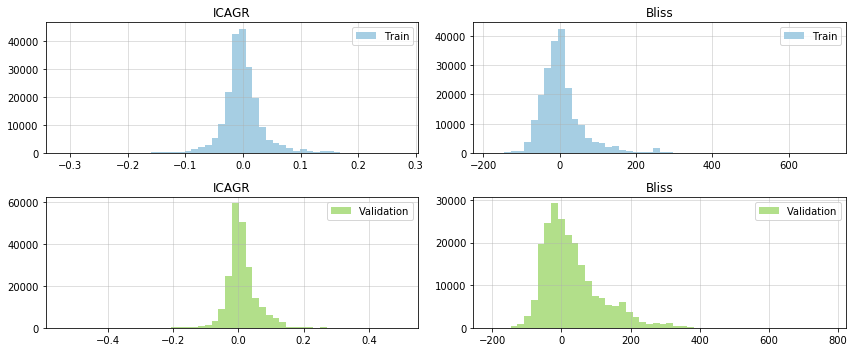

In [234]:
pal = pyplot.get_cmap('Paired').colors

plt.subplots(2, 2, figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.title('ICAGR')
res_train.ICAGR.hist(bins = 50, label='Train', color=pal[0])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 2)
plt.title('Bliss')
(res_train.Bliss * 364.25).hist(bins = 50, label='Train', color=pal[0])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 3)
plt.title('ICAGR')
res_val.ICAGR.hist(bins = 50, label='Validation', color=pal[2])
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(2, 2, 4)
plt.title('Bliss')
(res_val.Bliss * 364.25).hist(bins = 50, label='Validation', color=pal[2])
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()

Color: Bliss (days)


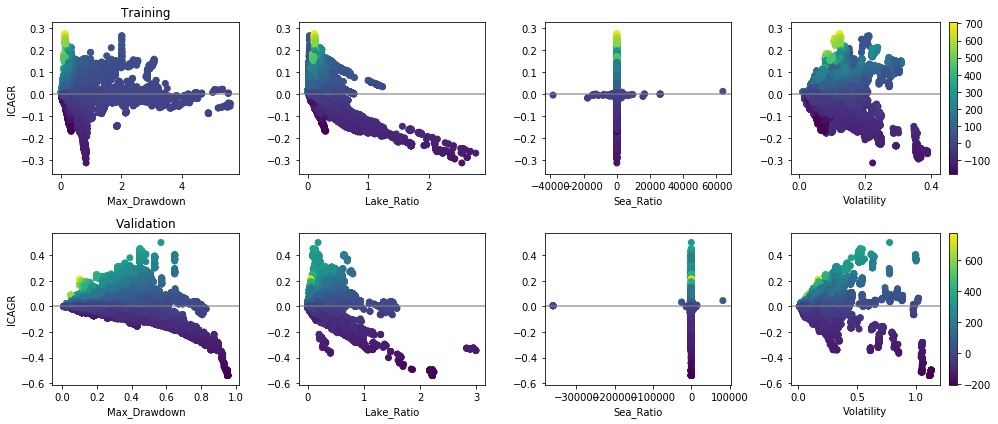

In [235]:
y_lab = ['ICAGR']
x_lab = ['Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']
c_lab = 'Bliss'

print('Color: ' + c_lab + ' (days)')
fig, axes = plt.subplots(nrows=2 * len(y_lab), ncols=len(x_lab), squeeze=False, figsize=(14, 6))

axes[0, 0].set_title('Training')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[i, j].scatter(res_train[x_lab[j]], res_train[y_lab[i]], c=res_train[c_lab] * 364.25)
    axes[i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[i, j])

axes[1, 0].set_title('Validation')
for i, j in itertools.product(np.arange(len(y_lab)), np.arange(len(x_lab))):
    im = axes[1 + i, j].scatter(res_val[x_lab[j]], res_val[y_lab[i]], c=res_val[c_lab] * 364.25)
    axes[1 + i, j].axhline(0, color='grey', alpha=0.75)
    if i == len(y_lab) - 1:
        axes[1 + i, j].set_xlabel(x_lab[j])
    if j == 0:
        axes[1 + i, j].set_ylabel(y_lab[i])
    if j == len(x_lab) - 1:
        fig.colorbar(im, ax=axes[1+i, j])
plt.tight_layout()

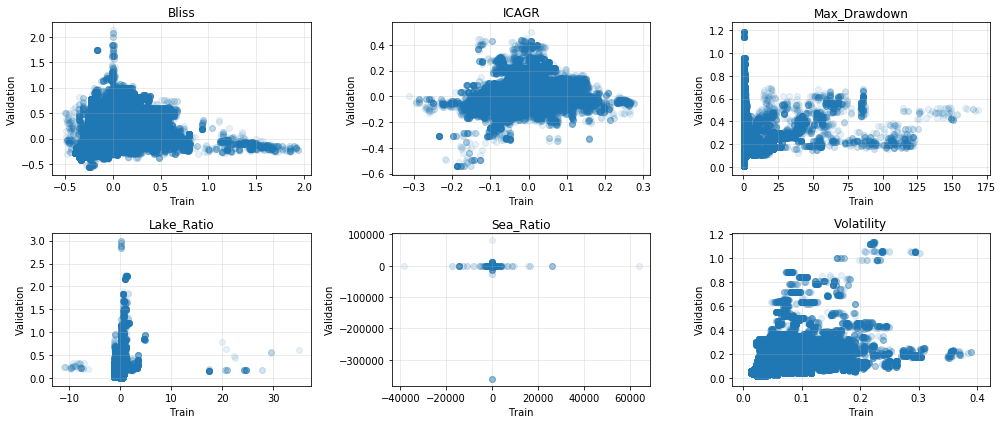

In [236]:
labs = ['Bliss', 'ICAGR', 'Max_Drawdown', 'Lake_Ratio', 'Sea_Ratio', 'Volatility']

nr = 2
nc = int(np.ceil(len(labs) / 2))
plt.subplots(nr, nc, squeeze=False, figsize=(14, 6))

for i in range(len(labs)):
    plt.subplot(nr, nc, i + 1)
    plt.scatter(res_train[labs[i]], res_val[labs[i]], alpha=0.1)
    plt.title(labs[i])
    plt.grid(alpha=0.3)
    plt.xlabel('Train')
    plt.ylabel('Validation')

plt.tight_layout()

In [237]:
def top_n(df, n=1, by='ICAGR', ascending=False):
    return df.dropna().sort_values(by, ascending=ascending).head(n)

top_n(results_df, by='Bliss', ascending=True)

,Name,Slow,Fast,Type,Years,Ratio,ICAGR,Max_Drawdown,Bliss,Volatility,Lake_Ratio,Sea_Ratio
0,XSES/BCY,245,20,Validation,5.737817,0.045437,-0.53878,0.954979,-0.56418,1.121003,2.220573,-1.0


In [238]:
res_gr = results_df.groupby(['Name', 'Type'])

In [239]:
top_Bliss = res_gr.apply(top_n, by='Bliss')
top_Bliss.index = np.arange(len(top_Bliss))
top_Bliss = top_Bliss.pivot(index = 'Name', columns='Type', values=['Slow', 'Fast'])

Bliss:


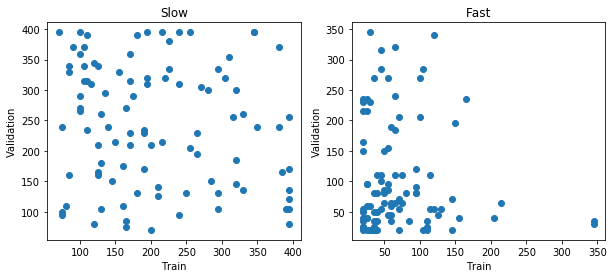

In [240]:
print('Bliss:')
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Slow')
plt.xlabel('Train')
plt.ylabel('Validation')
plt.scatter(top_Bliss['Slow']['Train'], top_Bliss['Slow']['Validation'])

plt.subplot(1, 2, 2)
plt.title('Fast')
plt.xlabel('Train')
plt.ylabel('Validation')
plt.scatter(top_Bliss['Fast']['Train'], top_Bliss['Fast']['Validation'])

In [241]:
top_ICAGR = res_gr.apply(top_n, by='ICAGR')
top_ICAGR.index = np.arange(len(top_ICAGR))
top_ICAGR = top_ICAGR.pivot(index = 'Name', columns='Type', values=['Slow', 'Fast'])

ICAGR:


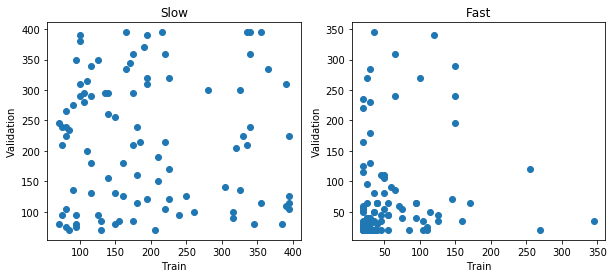

In [242]:
print('ICAGR:')
plt.subplots(1, 2, figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Slow')
plt.xlabel('Train')
plt.ylabel('Validation')
plt.scatter(top_ICAGR['Slow']['Train'], top_ICAGR['Slow']['Validation'])

plt.subplot(1, 2, 2)
plt.title('Fast')
plt.xlabel('Train')
plt.ylabel('Validation')
plt.scatter(top_ICAGR['Fast']['Train'], top_ICAGR['Fast']['Validation'])

# Exponential moving average System

In [135]:
from trading_strategies import *

In [136]:
es_j = ES2_Trading_Strategy(pr_j, equity=1e6, a=2 / 341, tr_stop_loss=0.1,#protective_pct=0.1,
                            name=str(j) + ' - ' + ticker_j)
es_j.excecute()

In [101]:
es_j.performance

{'Years': 19.470144131777626,
 'Ratio': 0.5674075934999993,
 'ICAGR': -0.029104939844645482,
 'Max_Drawdown': 0.5653479856783532,
 'Bliss': -0.05148146023678296,
 'Volatility': 0.14042411125804347,
 'Lake_Ratio': 0.6822773273825571,
 'Sea_Ratio': -1.2191528325847403}

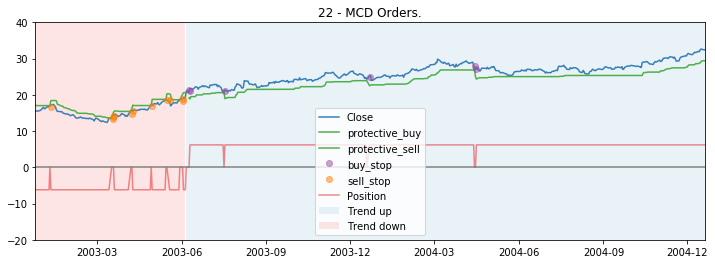

In [147]:
es_j.plot_orders()
plt.xlim((pr_j.index[1000], pr_j.index[1500]));
plt.ylim((-20, 40));

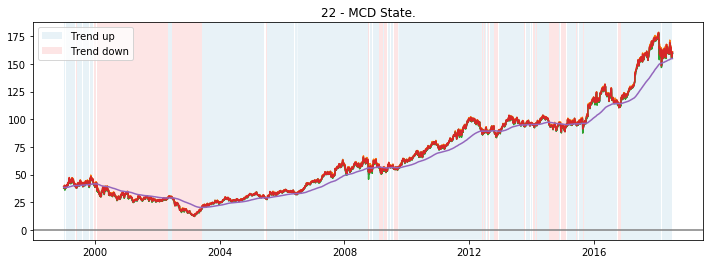

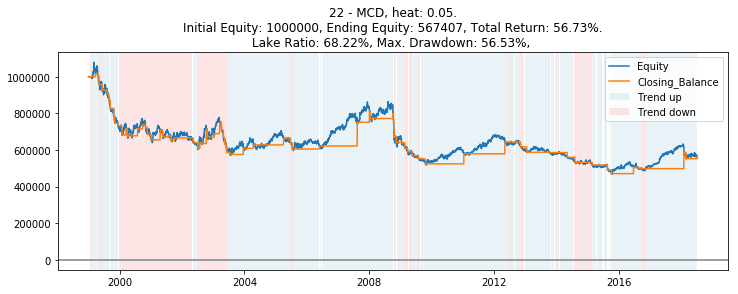

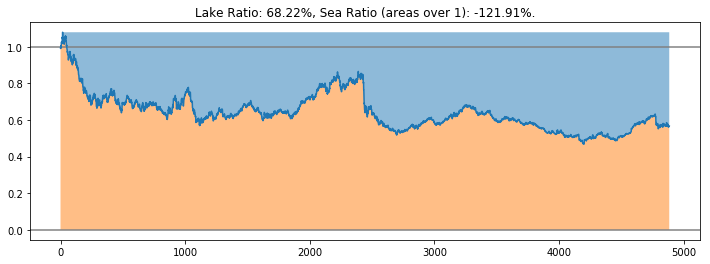

In [102]:
es_j.plot_state()
es_j.plot_orders()
es_j.plot_equity()
es_j.plot_lake_ratio()

# TO DO:

* Download all series.

# Other Ideas...

## Evolution strategies

See code example in OpenAI's [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://blog.openai.com/evolution-strategies/).

* TO DO: scypy: optimize.

In [ ]:
# Price
j = 15  # np.random.choice(len(prices_dict) - 1)
ticker = list(prices_dict.keys())[j]
pr = prices_dict[ticker_j]


# Optimization parameters
n_steps = 5
n_pop = 20       # population size
breadth = 50    # Maximum step to take in any direction (days_slow, days_fast)
breadth_heat = 0.1
alpha = 1     # learning rate
warmup = 400    # warmup period (days)
val_size = 0.3


# Parameter space
min_days, max_days = (30, 400)  
min_heat, max_heat = (0.01, 0.3) 


# Target indicator
def get_target(res):
    return np.clip(res['ICAGR'], 0, None)
#     return res['Max_Drawdown']


# Target function
def f(d_s, d_f, h, i=0, j=0):
    
    rs = RS_Trading_Strategy(pr_j, 
                             days_fast=int(d_f), 
                             days_slow=int(d_s),
                             heat=h)
    rs.excecute(warmup=400, end = 1 - val_size)
    
    out = [{'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'train', **rs.performance}]
    
    # Validation
    rs_val = RS_Trading_Strategy(pr_j, 
                                 days_fast=int(d_f), 
                                 days_slow=int(d_s),
                                 heat=h)
    rs_val.excecute(warmup=0.55)
    out.append({'i':i, 'j': j, 'Slow': d_s, 'Fast': d_f, 'Heat': h, 'Type': 'validation', **rs_val.performance})
    
    return out



# Initial parameters
days_s = np.random.choice(np.arange(min_days, max_days + 1))
days_f = np.random.choice(np.arange(min_days, days_s))
heat = np.random.uniform(min_heat, max_heat)


# Results
results = f(days_s, days_f, heat)
for i in range(n_steps):

    noise_s = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_f = np.random.choice(np.arange(-breadth, breadth), n_pop)
    noise_h = np.random.uniform(-breadth_heat, breadth_heat, n_pop)
    
    R = np.zeros(n_pop)
    for j in range(n_pop):
        s_try = np.clip(days_s + noise_s[j], min_days, max_days)
        f_try = np.clip(days_f + noise_f[j], min_days, s_try)
        h_try = np.clip(heat + noise_h[j], min_heat, max_heat)
        
        res_tr, res_val = f(s_try, f_try, h_try, i + 1, j + 1)
        results.append(res_tr)
        results.append(res_val)
        R[j] = get_target(res_tr)
        
    if np.sum(R) == 0:
        continue
    
    A = (R - np.min(R)) / (np.max(R) - np.min(R))  # np.std(R)
    
    days_s = np.clip(int(days_s + alpha * np.dot(noise_s.T, A) / np.sum(A)), min_days, max_days)
    days_f = np.clip(int(days_f + alpha * np.dot(noise_f.T, A) / np.sum(A)), min_days, days_s)
    heat = np.clip(heat + alpha * np.dot(noise_h.T, A) / np.sum(A), min_heat, max_heat)
    
    res_tr, res_val = f(days_s, days_f, heat, i + 1, j = 0)
    results.append(res_tr)
    results.append(res_val)
    
    if i % 1 == 0:
        print('i: ', i, ', days_slow: ', days_s, ', days_fast: ', days_f, ', heat: ', heat,
              '. Train: ', get_target(res_tr), '. Validation: ', get_target(res_val), '.', sep='')
    


In [ ]:
results_df = dict_list_to_DataFrame(results)
results_df